In [1]:
%load_ext autoreload
%autoreload 2

In [21]:
main_path = r'.'
data_path = main_path+'/data'
import sys
sys.path.append(main_path)
from BayDS.lib.pipeline import *
from typing import List, Set, Dict, Optional, Any, Tuple, Type, Union
from BayDS.lib.io import *
from BayDS.lib.training import *
import os

Using TensorFlow backend.
c:\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as

In [11]:
p = Pipeline(working_folder=f'{main_path}/Snapshots/1')
p.add_node(LoaderNode, None, 'train',
           params={
               'input_directory': data_path,
               'file': 'onetwotrip_challenge_train.csv'
           })
p.add_node(LoaderNode, None, 'test',
           params={
               'input_directory': data_path,
               'file': 'onetwotrip_challenge_test.csv'
           })
p.run()


---------------------------
0: LoaderNode [2019-12-15 18:55:58]
params:
 {'input_directory': './data', 'file': 'onetwotrip_challenge_train.csv'}
---------------------------
1: LoaderNode [2019-12-15 18:55:59]
params:
 {'input_directory': './data', 'file': 'onetwotrip_challenge_test.csv'}


In [12]:
def mix_train_test(dfs):
    df_train, df_test = dfs
    df_train['orderid'] = df_train['orderid'] + 1000000
    df_train = df_train.set_index('orderid')
    df_test = df_test.set_index('orderid')
    data = pd.concat([df_train, df_test], axis=0, sort=False )
    data.fillna(-1,inplace=True)
    return data

p.add_node(FunctionNode, ('train','test'),'data',
           params={
               'function': mix_train_test
           })
p.run()

---------------------------
2: FunctionNode [2019-12-15 18:56:02]
params:
 {'function': <function mix_train_test at 0x000001D250FDEF28>}


In [14]:
p.add_node(EraserNode, params={
    'remove_keys': ['train', 'test']
})
p.run()

---------------------------
3: EraserNode [2019-12-15 18:56:58]
params:
 {'remove_keys': ['train', 'test']}


In [27]:
# p.save()


'./Snapshots/1'

## Features

In [16]:
p.data['data'].columns

Index(['userid', 'field0', 'field1', 'field2', 'field3', 'field4', 'field5',
       'field6', 'field7', 'field8', 'field9', 'field10', 'field11', 'field12',
       'field13', 'field14', 'field15', 'field16', 'field17', 'field18',
       'field19', 'field20', 'field21', 'field22', 'field23', 'field24',
       'field25', 'field26', 'field27', 'field28', 'field29',
       'indicator_goal21', 'indicator_goal22', 'indicator_goal23',
       'indicator_goal24', 'indicator_goal25', 'goal21', 'goal22', 'goal23',
       'goal24', 'goal25', 'goal1'],
      dtype='object')

In [17]:
exclude_features_from_training = ['indicator_goal21', 'indicator_goal22', 'indicator_goal23',
       'indicator_goal24', 'indicator_goal25', 'goal21', 'goal22', 'goal23',
       'goal24', 'goal25', 'goal1','userid',]

## Training


In [18]:
data = p.data['data']
X = data[data['goal1']>=0].drop(['goal1'], axis=1)
y = data[data['goal1']>=0]['goal1']
test=data[data['goal1']<0]
train_features = [f for f in data.columns if f not in exclude_features_from_training]


In [19]:
from sklearn.model_selection import GroupKFold, KFold

NFOLDS = 5
folds = GroupKFold(n_splits=NFOLDS)
params = {
          'objective': 'binary',
          "metric": 'auc',
          "verbosity": -1,
         }
train_options = {
        "model_type":'lgb',
        "params": params,
        "eval_metric":'auc',
        'early_stopping_rounds': 100,
        'n_estimators': 500,
        'averaging': 'rank',
        'use_groups': False,
        'fold_name': folds.__class__.__name__,
        'n_splits': NFOLDS
    }

Fold 1 started at Sun Dec 15 19:17:47 2019
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.8352	training's auc: 0.8352	valid_1's auc: 0.660413	valid_1's auc: 0.660413
Early stopping, best iteration is:
[36]	training's auc: 0.769533	training's auc: 0.769533	valid_1's auc: 0.671052	valid_1's auc: 0.671052
Fold 2 started at Sun Dec 15 19:17:58 2019
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.832962	training's auc: 0.832962	valid_1's auc: 0.708005	valid_1's auc: 0.708005
Early stopping, best iteration is:
[27]	training's auc: 0.742707	training's auc: 0.742708	valid_1's auc: 0.71381	valid_1's auc: 0.713811
Fold 3 started at Sun Dec 15 19:18:06 2019
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.833846	training's auc: 0.833846	valid_1's auc: 0.684287	valid_1's auc: 0.684287
Early stopping, best iteration is:
[28]	training's auc: 0.753781	training's auc: 0.753782	valid_1's

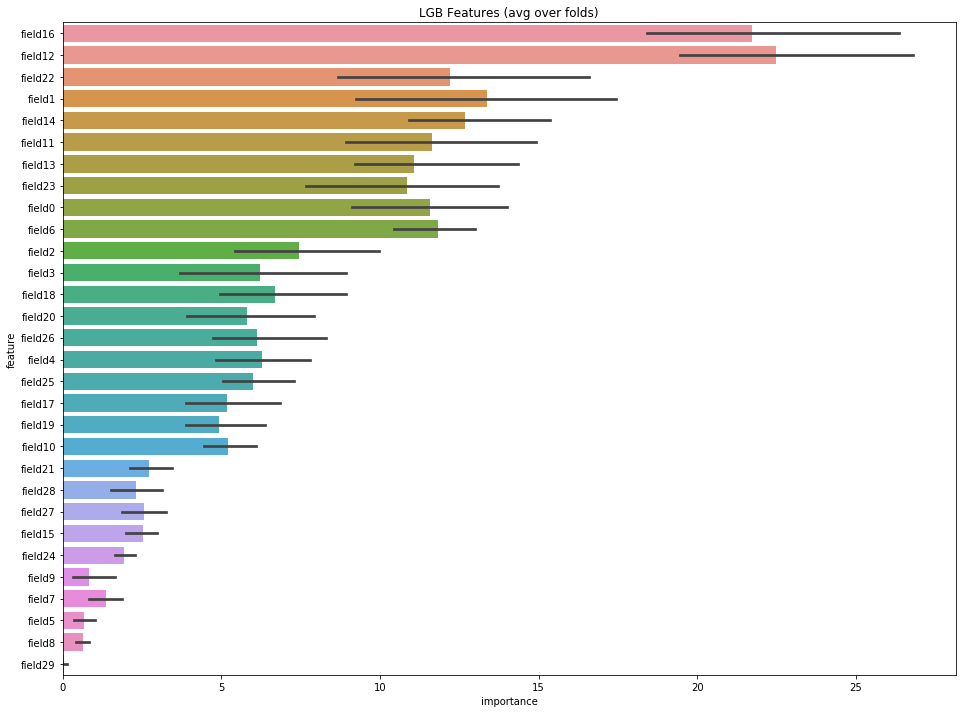

In [22]:
result_dict = train_model_classification_vb( X=X, 
                                             X_test=test, 
                                             columns=train_features,
                                             y=y, 
                                             params=params, folds=folds,
                                             model_type=train_options['model_type'], 
                                             plot_feature_importance=True,
                                             verbose=100, early_stopping_rounds=train_options['early_stopping_rounds'],
                                             n_estimators=train_options['n_estimators'], 
                                             averaging=train_options['averaging'],
                                             groups=X['userid'],
                                             n_jobs=-1)

In [39]:
import datetime
t = datetime.datetime.now().strftime("%m-%d-%H-%M")
test['proba'] = result_dict['prediction']
sub = pd.read_csv('data/onetwotrip_challenge_sub1.csv')
sub['proba'] = test['proba'] / test['proba'].max()
sub.reset_index(drop=True).set_index('orderid').to_csv(f'{p.working_folder}/submission-{t}.csv')

'12-15-19-30'